## DogvsCat Classifier  -  CNN using Transfer Learning Keras

Dataset Link :https://www.kaggle.com/c/dogs-vs-cats/data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow import keras

### Dividing into dirs

In [4]:
import os
import glob
import shutil
import random


if os.path.isdir("train/cat") is False:
    os.makedirs("train/cat")
    os.makedirs("train/dog")


for c in glob.glob("train/cat*"):
    shutil.move(c, "train/cat/")

for d in glob.glob("train/dog*"):
    shutil.move(d, "train/dog/")



cat = os.listdir("train/cat")
dog = os.listdir("train/dog")

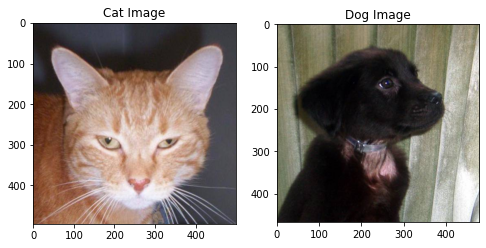

In [5]:
fig, ax = plt.subplots(1,2, figsize=(8,8))

imgc = cv2.imread("train/cat/"+cat[2])
imgc = cv2.cvtColor(imgc, cv2.COLOR_BGR2RGB)
ax[0].set_title("Cat Image")
ax[0].imshow(imgc)

imgd = cv2.imread("train/dog/"+dog[4])
imgd = cv2.cvtColor(imgd, cv2.COLOR_BGR2RGB)
ax[1].set_title("Dog Image")
ax[1].imshow(imgd)
plt.show()

### Preprocessing

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess


image_gen = ImageDataGenerator(preprocessing_function=vgg_preprocess, validation_split=0.3)

In [17]:
batch_size = 128

train_batches = image_gen.flow_from_directory(directory="train/",
                                              target_size=(224,224),
                                              classes=["cat", "dog"],
                                              batch_size=batch_size,
                                              subset="training")


test_batches = image_gen.flow_from_directory(directory="train/",
                                              target_size=(224,224),
                                              classes=["cat", "dog"],
                                              batch_size=batch_size,
                                              shuffle=False,
                                              subset="validation")

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


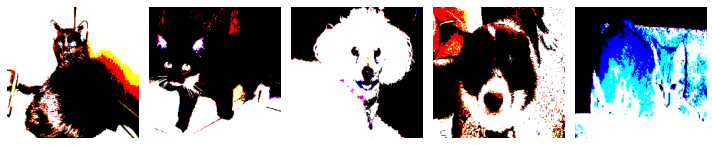

Labels : [1. 0.]		[1. 0.]		[0. 1.]		[0. 1.]		[1. 0.]		

In [36]:
# imgs, labels = next(train_batches)

fig, axes = plt.subplots(1,5, figsize=(10,10))
axes = axes.flatten()

for img, ax in zip(imgs, axes):
    ax.imshow(img, cmap="gray")
    ax.axis('off')
    
plt.tight_layout()
plt.show()

print("Labels : ", end="")
for l in labels[:5]:
    print(l, end="\t\t")

##     

## CNN Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

model = Sequential()

model.add( Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation="relu") )
model.add( MaxPool2D(pool_size=(2,2)) )

model.add( Conv2D(filters=64, kernel_size=(3,3), activation="relu") )
model.add( MaxPool2D(pool_size=(2,2)) )

model.add(Flatten())
model.add(Dense(2, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=1)

In [35]:
predictions = model.fit(train_batches, epochs=20, 
                                  validation_data = test_batches,
                                  callbacks=[early_stop])

Epoch 1/20
137/137 [==============================] - 84s 613ms/step - loss: 0.3585 - accuracy: 0.8430 - val_loss: 0.6414 - val_accuracy: 0.6923
Epoch 2/20
137/137 [==============================] - 83s 609ms/step - loss: 0.2662 - accuracy: 0.8954 - val_loss: 0.6962 - val_accuracy: 0.6948


### Transfer Learning using VGG16 Model

In [45]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_model = VGG16()
#vgg16_model.summary()

In [49]:
TL_model = Sequential()

for layer in vgg16_model.layers[:-1]:
    TL_model.add(layer)

for layer in model.layers:
    layer.trainable = False

TL_model.add(Dense(2, activation="softmax"))
TL_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [50]:
TL_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience=1)

In [51]:
predictions = model.fit(train_batches, epochs=20, 
                                  validation_data = test_batches,
                                  callbacks=[early_stop])

Epoch 1/20
137/137 [==============================] - 122s 860ms/step - loss: 0.1549 - accuracy: 0.9398 - val_loss: 0.0562 - val_accuracy: 0.9823
Epoch 2/20
137/137 [==============================] - 112s 817ms/step - loss: 0.0399 - accuracy: 0.9844 - val_loss: 0.0546 - val_accuracy: 0.9836
Epoch 3/20
137/137 [==============================] - 112s 819ms/step - loss: 0.0249 - accuracy: 0.9903 - val_loss: 0.0541 - val_accuracy: 0.9848
Epoch 4/20
137/137 [==============================] - 112s 818ms/step - loss: 0.0182 - accuracy: 0.9936 - val_loss: 0.0616 - val_accuracy: 0.9832


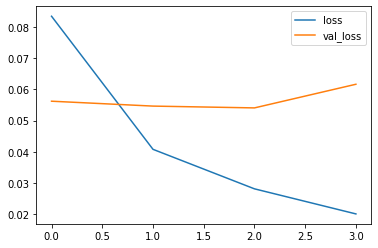

In [52]:
metrics = pd.DataFrame(model.history.history)
metrics[["loss","val_loss"]].plot()

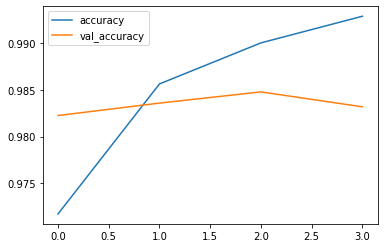

In [53]:
metrics[["accuracy","val_accuracy"]].plot()

### TL_Model Evaluation

In [54]:
predictions = model.evaluate(test_batches)

print("Loss : ",predictions[0])
print("Accuracy : ",predictions[1]*100,"%")

59/59 [==============================] - 34s 562ms/step - loss: 0.0616 - accuracy: 0.9832
Loss :  0.0616319514811039
Accuracy :  98.32000136375427 %


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_batches)
y_pred = np.argmax(predictions, axis=-1)

print(classification_report(test_batches.classes, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3750
           1       0.99      0.98      0.98      3750

    accuracy                           0.98      7500
   macro avg       0.98      0.98      0.98      7500
weighted avg       0.98      0.98      0.98      7500



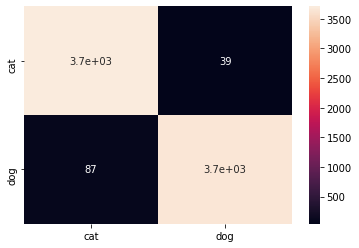

In [59]:
class_labels = ["cat", "dog"]

mat = confusion_matrix(test_batches.classes, y_pred)
sns.heatmap(mat, xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.show()